In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import json
import os
from os import listdir
from os.path import isfile, join
from pycocotools import mask as _mask
import torch

from h_maskcut import *
from h_detectron2 import *

## Dataset

In [3]:
syspath="/home/dkhatanassia/detectron2_dataset"

dataset = 'jerry_2500GT'
root = join(syspath,dataset)
imgs_mc = join(root,'imgs_mc')
imgs_tau = join(root,'imgs_tau')
anns = join(root,'annotations')
anns_tmp = join(anns,'sub')

# json file default name
nb_mask = 3
tau_graph = 0.55
json_name_mc = f'{dataset}_N{nb_mask}_tau{tau_graph}.json'
json_path_mc = join(anns, json_name_mc)

## MaskCut

In [5]:
taus = np.arange(0.05,1,0.05).round(2)
tmp_imgs=imgs_tau

for tau_graph in [0.55]:
    json_name_mc = f'{dataset}_N{nb_mask}_tau{tau_graph}.json'
    json_path_mc = join(anns, json_name_mc)
    
    %cd ~/CutLER/maskcut
    # run MaskCut 
    fpj = 1
    nb_folder = len([f for f in listdir(tmp_imgs) if not 'ipynb' in f])
    assert nb_folder/fpj==int(nb_folder/fpj), f'{nb_folder} is not multiple of {fpj}'

    #run MaskCut 
    print(f"########## run MaskCut: tau={tau_graph}, N={nb_mask} ##########")
    for i in range(int(nb_folder/fpj)):
        torch.cuda.empty_cache()
        print("### folders: {0}-{1} ###".format(fpj*i,fpj*i+fpj))
        %run maskcut.py \
        --vit-arch base --patch-size 8 \
        --tau '{tau_graph}' --fixed_size 480 --N '{nb_mask}' \
        --num-folder-per-job '{fpj}' --job-index '{i}' \
        --dataset-path '{tmp_imgs}' \
        --out-dir '{anns_tmp}'
        
    print("\n########## merge json files ##########")
    # merge annotation files
    !python merge_jsons.py \
    --base-dir '{anns_tmp}' \
    --num-folder-per-job '{fpj}' --fixed-size 480 \
    --tau '{tau_graph}' --N '{nb_mask}' \
    --save-path '{json_path_mc}'

/home/dkhatanassia/CutLER/maskcut
########## run MaskCut: tau=0.55, N=3 ##########
### folders: 0-1 ###
Loading weight from https://dl.fbaipublicfiles.com/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth
Load base pre-trained feature...


100%|██████████| 50/50 [05:05<00:00,  6.11s/it]


dumping /home/dkhatanassia/detectron2_dataset/jerry_2500GT/annotations/sub/imagenet_train_fixsize480_tau0.55_N3_0_1.json
Done: 50 images; 111 anns.
### folders: 1-2 ###
Loading weight from https://dl.fbaipublicfiles.com/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth
Load base pre-trained feature...


100%|██████████| 50/50 [05:02<00:00,  6.06s/it]

dumping /home/dkhatanassia/detectron2_dataset/jerry_2500GT/annotations/sub/imagenet_train_fixsize480_tau0.55_N3_1_2.json
Done: 50 images; 116 anns.

########## merge json files ##########
Done: 100 images; 227 anns.


## Visualization

registered: jerry_2500GT_N3_tau0.55.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_2500GT/annotations/jerry_2500GT_N3_tau0.55.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_2500GT/imgs_tau



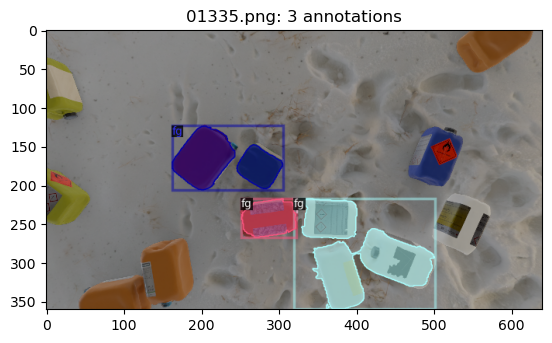

In [12]:
registerCatalog(json_name_mc,json_path_mc, tmp_imgs)
visualizeSample(5,json_name_mc)